In [23]:
import numpy as np
import pandas as pd
import os
import random
import h5py
import torch
import torch.nn as nn
import jax

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from torch.utils.data import DataLoader, TensorDataset

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import corner

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

sun_numax = 3090

## Neural network 

In [24]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  
            nn.ReLU(),
            nn.Linear(256, 256),  # 2
            nn.ReLU(),
            nn.Linear(256, 256),  # 3
            nn.ReLU(),
            nn.Linear(256, 256),  # 4
            nn.ReLU(),
            nn.Linear(256, 256),  # 5
            nn.ReLU(),
            nn.Linear(256, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
ckpt_path = "best_model_v8-1-epoch=9965-val_loss=0.0071.ckpt"
input_dim = 7  # Number of input features
output_dim = 5  # Number of output features
model = GarstecNet.load_from_checkpoint(ckpt_path, input_dim=input_dim, output_dim=output_dim)
device = torch.device("cpu")
model.to(device)
model.eval()  

GarstecNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=5, bias=True)
  )
  (criterion): MSELoss()
)

## Importing scaling relations

In [25]:
import joblib

scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

## Extracting data for specific track

In [26]:
import jax.numpy as jnp

# Plotting for neural network and garstec track: 07298
specific_track_name = 'track01624'

# Retrieve all required inputs for track: 07298
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    age_07298 = specific_track['age'][:].reshape(-1, 1)
    massini_07298 = specific_track['massini'][:].reshape(-1, 1)
    fehini_07298 = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt_07298 = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini_07298 = specific_track['yini'][:].reshape(-1, 1)
    eta_07298 = specific_track['eta'][:].reshape(-1, 1)
    alphafe_07298 = specific_track['alphaFe'][:].reshape(-1, 1)

    # Retrieve actual values for plotting
    teff_07298 = specific_track['Teff'][:]
    luminosity_07298 = specific_track['LPhot'][:]
    dnufit_07298 = specific_track['dnufit'][:]
    FeH_07298 = specific_track['FeH'][:]
    numax_07298 = specific_track['numax'][:]

# Using a single age point from the middle of the ages:

index_07298 = round(len(age_07298)/2)

age_07298_ = age_07298[index_07298]
massini_07298_ = massini_07298[index_07298]
fehini_07298_ = fehini_07298[index_07298]
alphamlt_07298_ = alphamlt_07298[index_07298]
yini_07298_ = yini_07298[index_07298]
eta_07298_ = eta_07298[index_07298]
alphafe_07298_ = alphafe_07298[index_07298]


teff_07298_ = teff_07298[index_07298]
luminosity_07298_ = luminosity_07298[index_07298]
dnufit_07298_ = dnufit_07298[index_07298]
FeH_07298_ = FeH_07298[index_07298]
numax_07298_ = numax_07298[index_07298]


## Emulate function for Bayesian model

In [27]:
state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x

In [28]:
obs_err = {
    'teff_err': [70],
    'lum_err': [0.1],
    'dnu_err': [0.1],
    'feh_err': [0.1],
    'numax_err': [0.5]
}

teff_obs = teff_07298_ + np.random.randn() * obs_err['teff_err'][0]
lum_obs = luminosity_07298_ + np.random.randn() * obs_err['lum_err'][0]
dnu_obs = dnufit_07298_ + np.random.randn() * obs_err['dnu_err'][0]
FeH_obs = FeH_07298_ + np.random.randn() * obs_err['lum_err'][0]
numax_obs = numax_07298_ * sun_numax + np.random.randn() * obs_err['numax_err'][0]

obs = {
    'teff': [teff_obs],
    'lum': [lum_obs],
    'dnu': [dnu_obs],
    'feh': [FeH_obs],
    'numax': [numax_obs],
}



## Bayesian model

In [29]:
def Bmodel(obs=None):
    # Define priors

    massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(2, 2)) + 0.7)
    tau_hat = numpyro.deterministic("tau_hat", 4 * numpyro.sample("tau_hat_s", dist.Beta(1.25, 2)) + 1) 

    # Calculate values for joint prior: 
    tau_ms = (2700) * (massini_**-3.15)
    ages_ = numpyro.deterministic("ages_", jnp.minimum(tau_hat * tau_ms, 20000)) # jnp.min to avoid values outside of grid

    # Rest of priors:
    alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 1.5)
    yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.22)
    eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 2)))
    alphafe_ = numpyro.deterministic("alphafe_", 0.8 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.2) 
    fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2)

    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, yini_] 
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.hstack(log_transformed_inputs + [fehini_, alphafe_])


    # Scale x manually
    mean_x = scaler_X.mean_
    scale_x = scaler_X.scale_  
    x_scaled = (x - mean_x) / scale_x

    # Emulate using PyTorch model
    y_scaled = emulate(x_scaled)
    
    # De-scale y manually 
    mean_y = jnp.array(scaler_y.mean_)  
    std_y = jnp.array(scaler_y.scale_)
    y = y_scaled * std_y + mean_y

    # Extract predictions
    teff = numpyro.deterministic("teff", jnp.power(10.0, y[..., 0])) 
    lum = numpyro.deterministic("lum", jnp.power(10.0, y[..., 1])) 
    dnu = numpyro.deterministic("dnu", jnp.power(10.0, y[..., 2]))
    numax = numpyro.deterministic("numax", jnp.power(10.0, y[..., 3])) * sun_numax
    feh = numpyro.deterministic("feh", y[..., 4])

    
    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, obs_err['teff_err'][0]), obs=obs['teff'][0])
        numpyro.sample("lum_obs", dist.StudentT(5, lum, obs_err['lum_err'][0]), obs=obs['lum'][0])
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, obs_err['dnu_err'][0]), obs=obs['dnu'][0])
        numpyro.sample("feh_obs", dist.StudentT(5, feh, obs_err['feh_err'][0]), obs=obs['feh'][0])
        numpyro.sample("numax_obs", dist.StudentT(5, numax, obs_err['numax_err'][0]), obs=obs['numax'][0])

## Prior predictive

In [30]:
from numpyro.infer import Predictive

from jax import random

prior_predictive = Predictive(Bmodel, num_samples=1000)
samples = prior_predictive(jax.random.PRNGKey(0))

In [31]:
# fig = corner.corner(samples, var_names=['teff', 'lum', 'dnu', 'feh', 'numax'], show_titles=True)
# plt.show()

In [32]:
from jax import random

nuts_kernel = NUTS(Bmodel)

prior_mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=4000)
rng_key = random.PRNGKey(0)
prior_mcmc.run(rng_key, obs=None)

posterior_samples = prior_mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [00:06<00:00, 1237.82it/s, 7 steps of size 5.61e-01. acc. prob=0.93]


c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


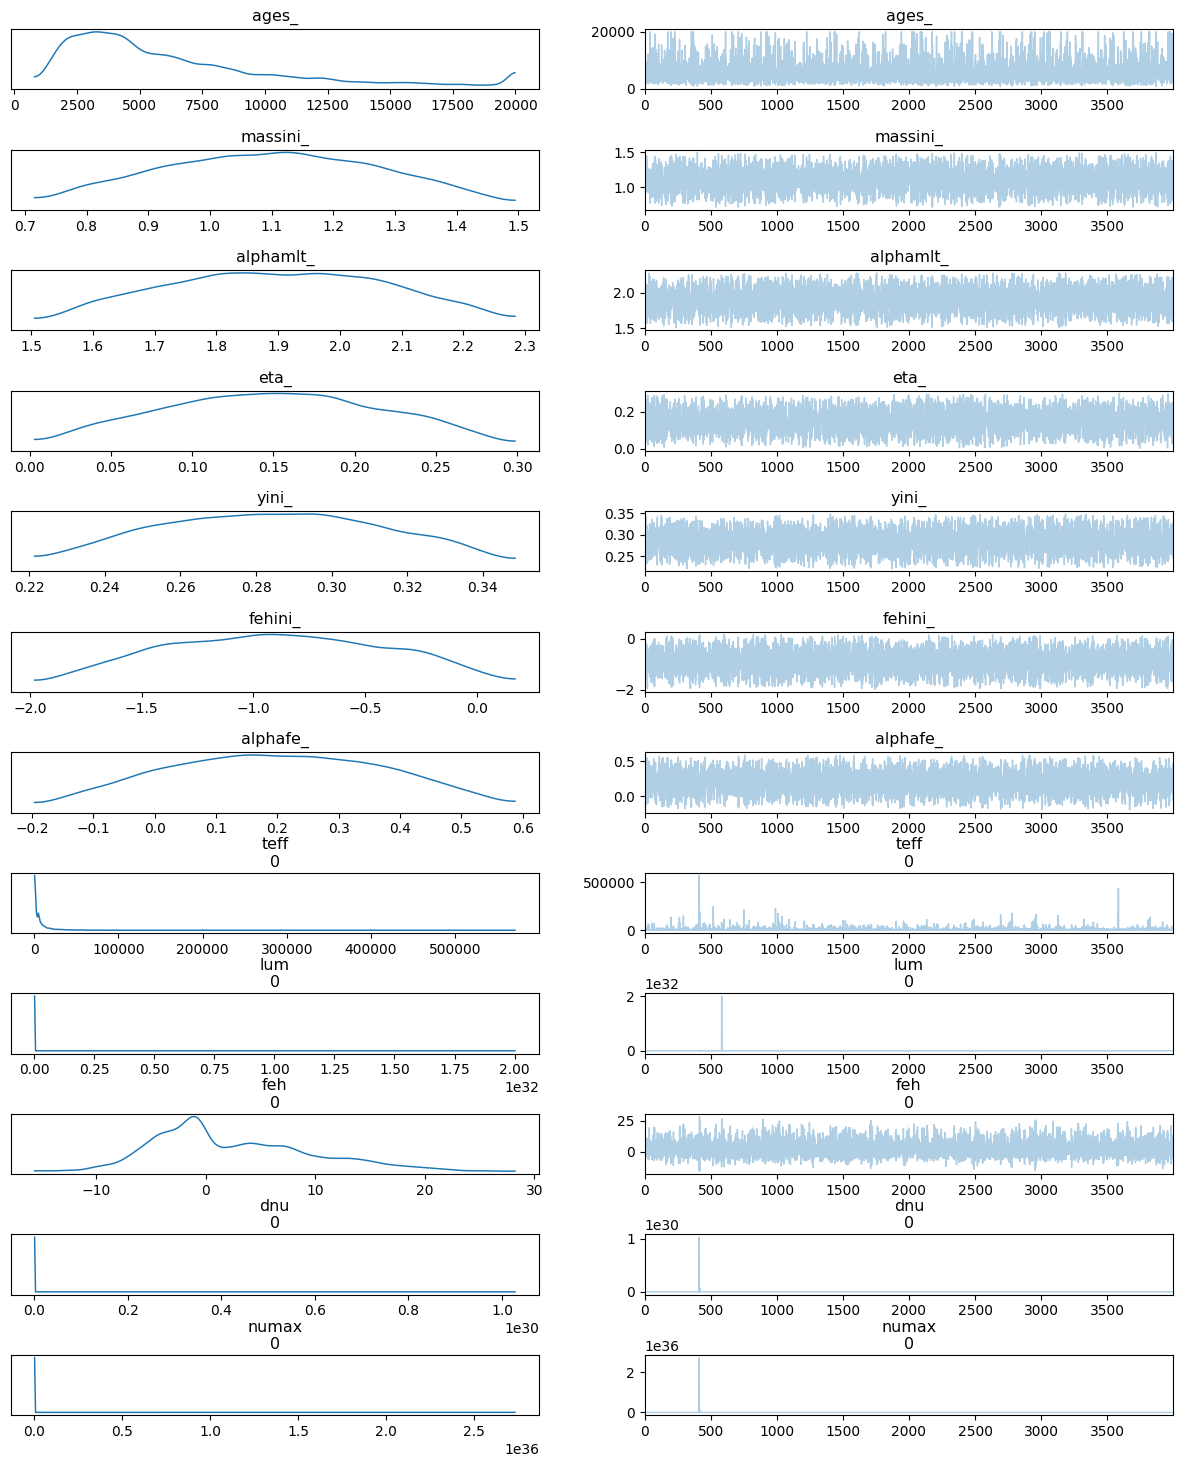

In [33]:
import arviz as az

prior_trace = az.from_numpyro(prior_mcmc)
az.plot_trace(prior_trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_',
                                       'alphafe_', 'teff', 'lum', 'feh', 'dnu', 'numax'], compact=False, figsize=(15, 18));  

plt.subplots_adjust(hspace=1)  

[9611.560365, 0.845, 1.97304687, 0.177978516, 0.27909668, -1.05361328, 0.2]


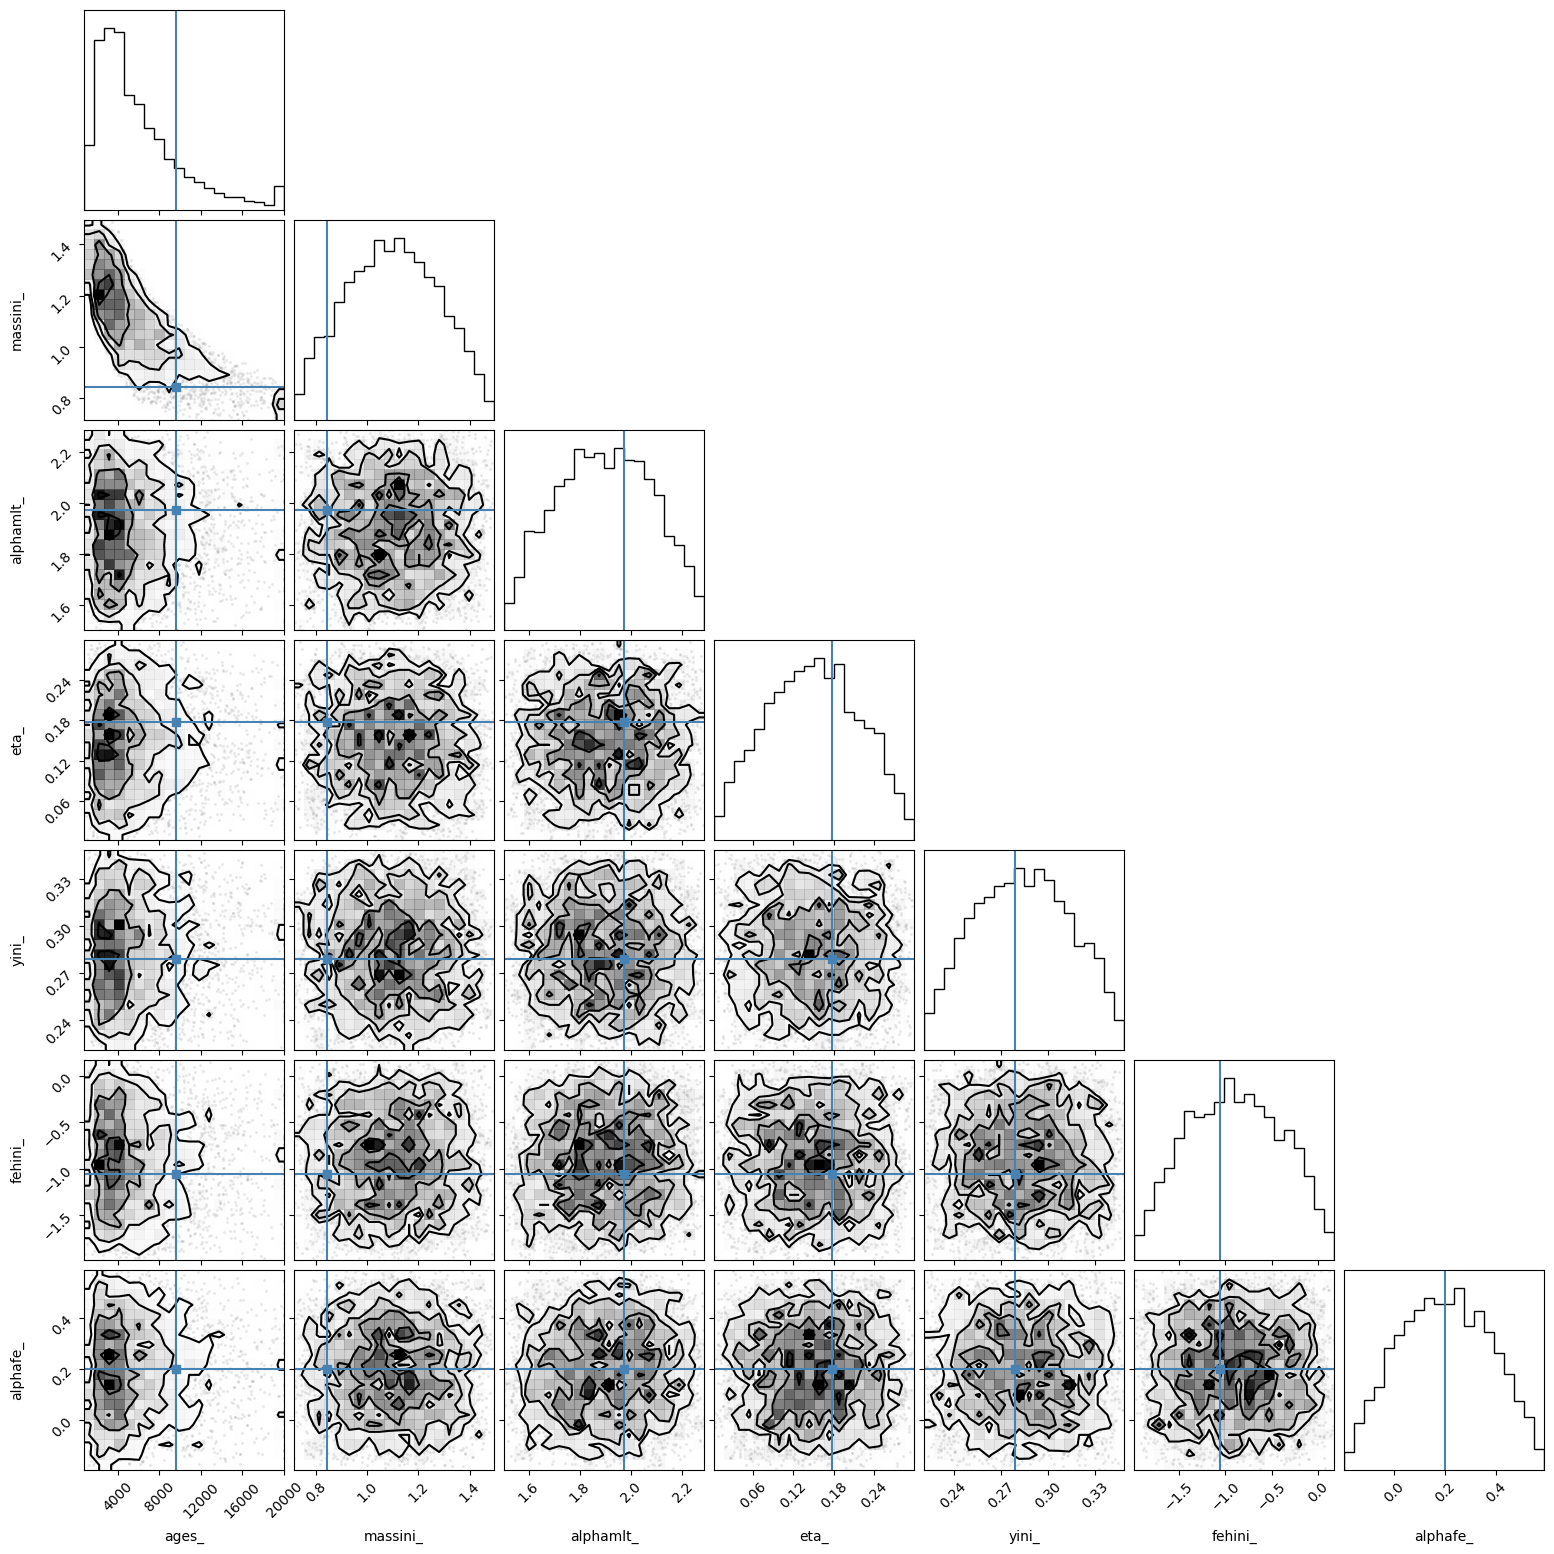

In [34]:
truths_prior = truth_values = [age_07298[0].item(), massini_07298[0].item(),
                                alphamlt_07298[0].item(), eta_07298[0].item(),
                                  yini_07298[0].item(),  fehini_07298[0].item(),
                                    alphafe_07298[0].item()]
print(truth_values)

corner.corner(prior_trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             truths = truths_prior);


## Running model and Posterior plotting 

In [35]:
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4) # between 1000 and 4000 for testing 
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=obs)

C:\Users\Dell\AppData\Local\Temp\ipykernel_9320\2324018506.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4) # between 1000 and 4000 for testing
sample: 100%|██████████| 2000/2000 [02:18<00:00, 14.48it/s, 1023 steps of size 2.12e-04. acc. prob=0.88]


In [36]:
trace = az.from_numpyro(mcmc)

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_,10387.636,3725.126,4859.321,16938.564,1808.600,1378.827,5.0,20.0,3.22
alphafe_,0.158,0.167,-0.129,0.329,0.073,0.055,6.0,12.0,2.04
alphafe_s,0.447,0.209,0.089,0.661,0.091,0.069,6.0,12.0,2.04
alphamlt_,1.823,0.178,1.530,2.030,0.080,0.060,6.0,24.0,1.88
alphamlt_s,0.404,0.222,0.037,0.662,0.100,0.075,6.0,24.0,1.88
dnu[0],4.052,0.688,3.542,5.319,0.340,0.260,6.0,28.0,1.80
eta_,0.160,0.056,0.052,0.251,0.024,0.019,6.0,18.0,1.84
eta_s,0.533,0.185,0.175,0.836,0.079,0.063,6.0,18.0,1.84
feh[0],-1.054,0.139,-1.277,-0.886,0.068,0.052,5.0,21.0,2.48
fehini_,-1.012,0.075,-1.158,-0.899,0.033,0.025,5.0,13.0,2.15


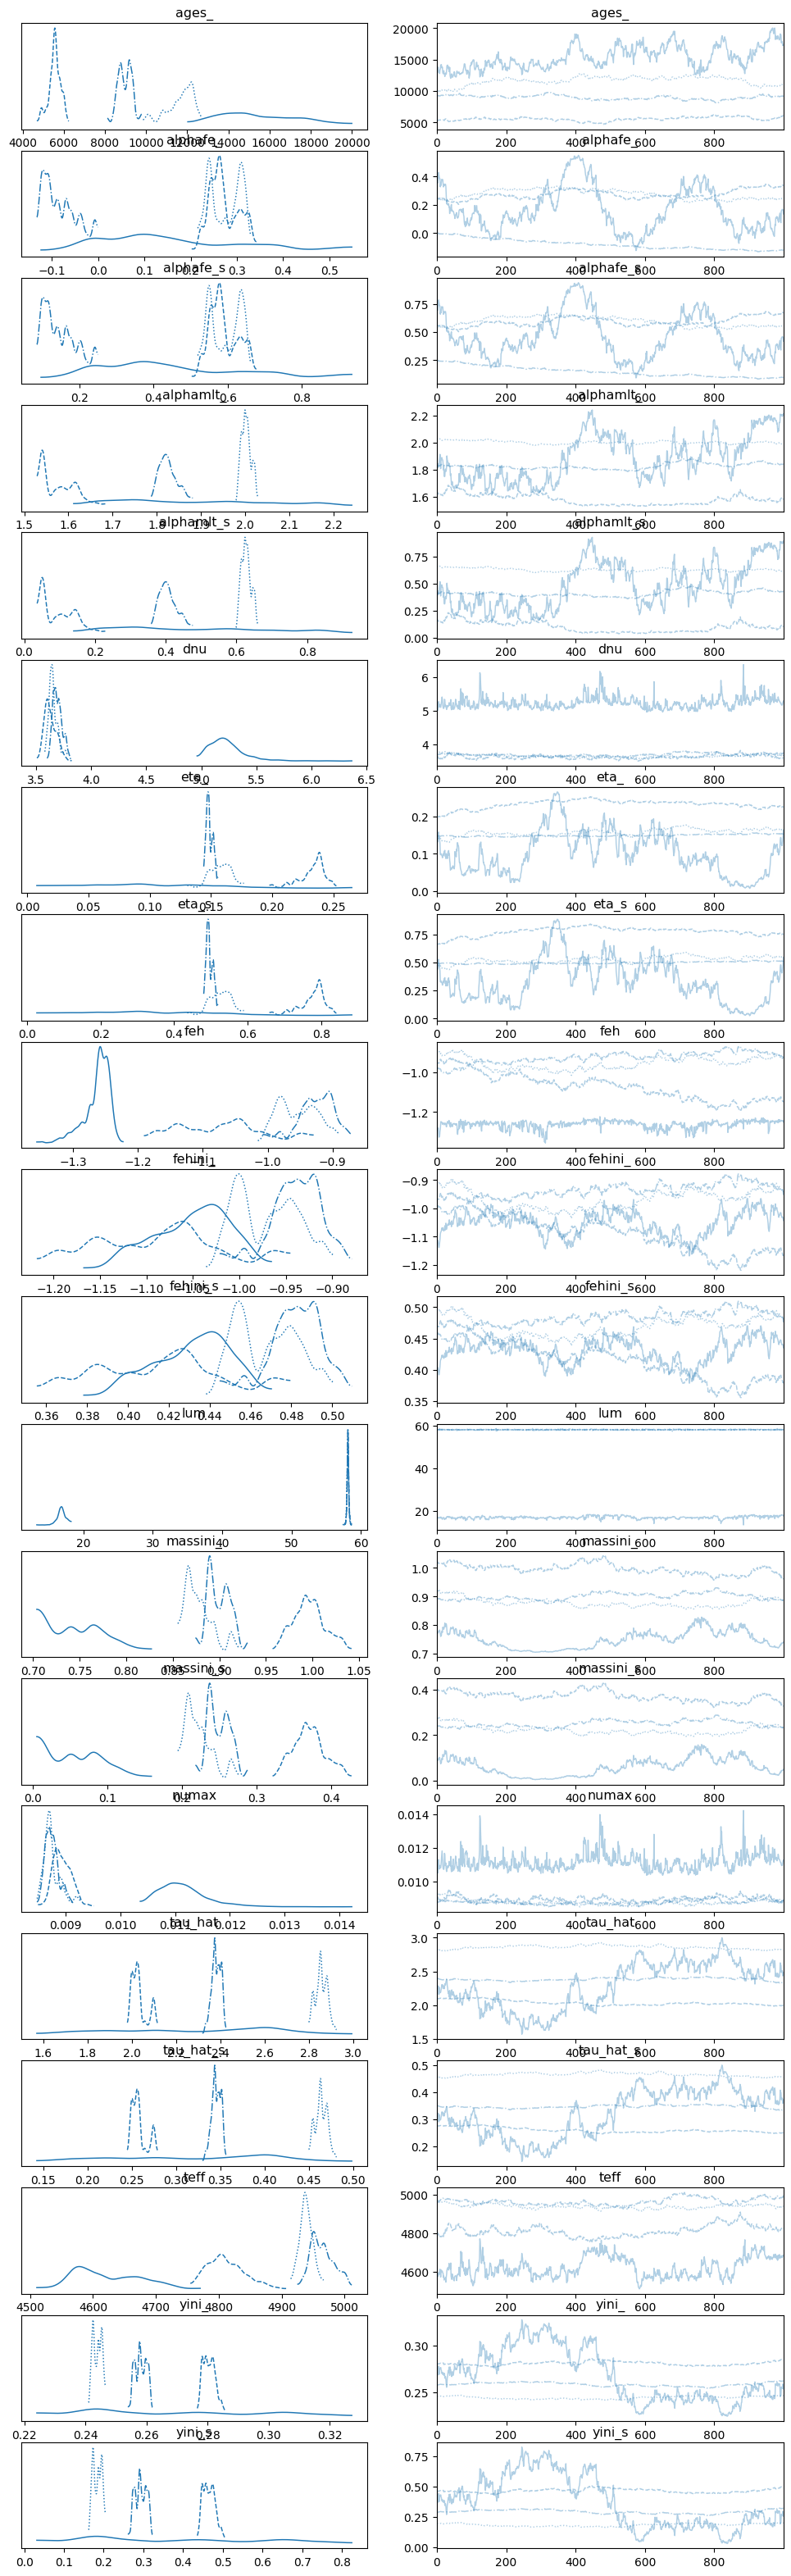

In [37]:
az.plot_trace(trace);

[10018.17118, 0.845, 1.97304687, 0.177978516, 0.27909668, -1.05361328, 0.2]


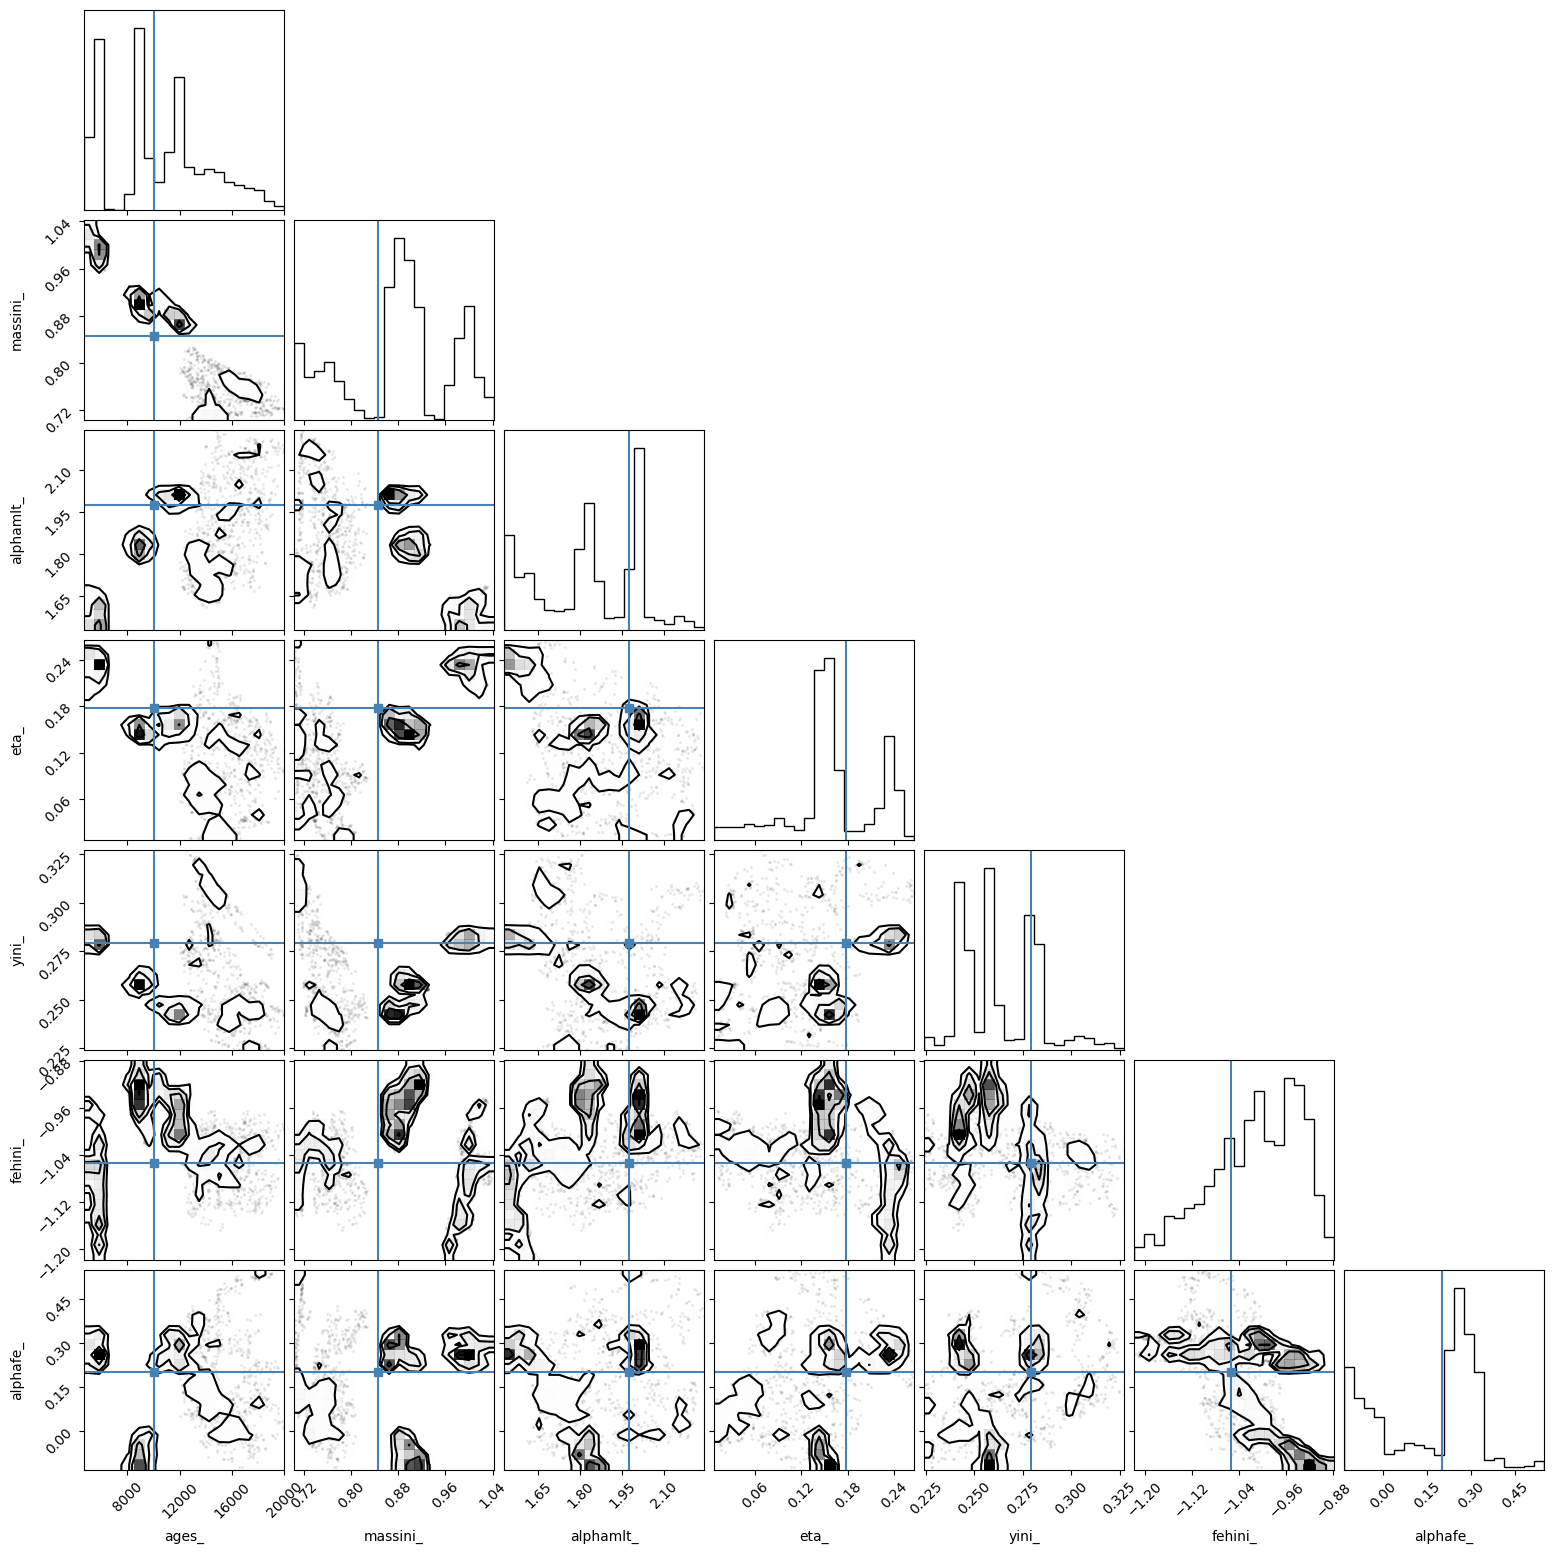

In [38]:
# Setting truth values for corner plot
truth_values = [age_07298_.item(), massini_07298[0].item(), 
                alphamlt_07298[0].item(), eta_07298[0].item(),
                yini_07298[0].item(),  fehini_07298[0].item(),
                alphafe_07298[0].item()]
print(truth_values)
import corner

corner.corner(trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             truths = truth_values);

In [39]:
from sklearn.preprocessing import MinMaxScaler


# Extract the variables from the trace
ages_samples = trace.posterior['ages_'].values.flatten()
mass_samples = trace.posterior['massini_'].values.flatten()
mlt_samples = trace.posterior['alphamlt_'].values.flatten()
eta_samples = trace.posterior['eta_'].values.flatten()
yini_samples = trace.posterior['yini_'].values.flatten()
fehini_samples = trace.posterior['fehini_'].values.flatten()
fe_samples = trace.posterior['alphafe_'].values.flatten()

closest_index = np.argmin(np.abs(mass_samples - massini_07298_))

length = len(age_07298)
      
ages_indices = []

for i in range(length):
    # Find the index in ages_samples closest to the current age value
    closest_index = np.argmin(np.abs(ages_samples - age_07298[i]))
    ages_indices.append(closest_index)


# Select the next `length` values after the min_age index
ages_subsample = np.sort(ages_samples[ages_indices]).reshape(-1, 1)
mass_subsample = np.full(length, mass_samples[closest_index]).reshape(-1, 1) 
mlt_subsample = np.full(length, np.mean(mlt_samples)).reshape(-1, 1)
eta_subsample = np.full(length, np.mean(eta_samples)).reshape(-1, 1) 
yini_subsample = np.full(length, np.mean(yini_samples)).reshape(-1, 1) 
fehini_subsample = np.full(length, np.mean(fehini_samples)).reshape(-1, 1) 
fe_subsample = np.full(length, np.mean(fe_samples)).reshape(-1, 1) 

epsilon = 1e-10
log10_hbm_inputs = [age_07298, mass_subsample, mlt_subsample, eta_subsample, yini_subsample] 
log10_transformed_hbm_inputs = [np.log10(np.maximum(data, epsilon)) for data in log10_hbm_inputs]

# Combine log-transformed inputs with raw `fehini` and `alpha fe`
features = np.hstack(log10_transformed_hbm_inputs + [fehini_subsample, fe_subsample])

features_numpy = np.array(features)  # Convert to numpy for scaling

features_scaled = scaler_X.transform(features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor

features_tensor = torch.FloatTensor(features_scaled)


In [40]:
print(mass_subsample[0],
mlt_subsample[0],
eta_subsample[0],
yini_subsample[0],
fehini_subsample[0],
fe_subsample[0])

print(massini_07298_, alphamlt_07298_, eta_07298_, yini_07298_, fehini_07298_, alphafe_07298_)

[0.91391253] [1.8233505] [0.15999301] [0.26260343] [-1.0118176] [0.15766045]
[0.845] [1.97304687] [0.17797852] [0.27909668] [-1.05361328] [0.2]


<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Dell\AppData\Local\Temp\ipykernel_9320\2887813514.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
C:\Users\Dell\AppData\Local\Temp\ipykernel_9320\2887813514.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(f"Log Luminosity ($\log(L_\odot)$)")


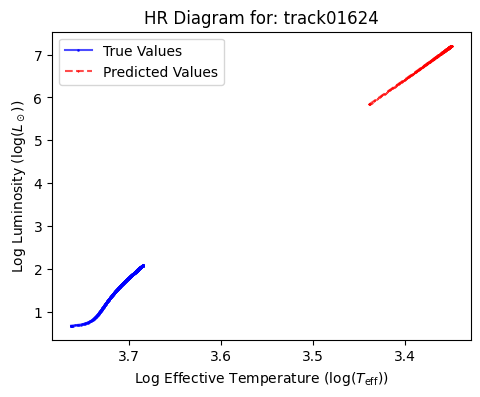

In [41]:
model.eval()
with torch.no_grad():
    predictions_hbm = model(features_tensor).numpy()  # Make predictions
    predictions_hbm1 = scaler_y.inverse_transform(predictions_hbm)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
hbm_teff = 10**predictions_hbm1[:, 0]  # Inverse log10 transformation
hbm_luminosity = 10**predictions_hbm1[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_07298)
log_actual_luminosity = np.log10(luminosity_07298)

# Log-transform predicted values for plotting
log_hbm_teff = np.log10(hbm_teff)
log_hbm_luminosity = np.log10(hbm_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(5.4, 4))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_hbm_teff, log_hbm_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel(f"Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()